## **Unzip Dataset**

In [1]:
import zipfile
import os

def unzip_file(zip_file_path, extract_to_path):
    # Check if the specified zip file exists
    if not os.path.exists(zip_file_path):
        print(f"The file {zip_file_path} does not exist")
        return

    # Create the directory if it does not exist
    if not os.path.exists(extract_to_path):
        os.makedirs(extract_to_path)

    # Unzip the file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_path)
        print(f"Extracted all files to {extract_to_path}")

zip_file_path = '/content/skin2_split.zip'
extract_to_path = '/content'
unzip_file(zip_file_path, extract_to_path)


Extracted all files to /content


## **Install library numpy versi 1.24.3**

In [2]:
!pip install numpy==1.24.3

## **Import library**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, optimizers, models, callbacks
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix

## **Accuracy Callback Stoping**

In [4]:
class AccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get("accuracy")
        val_accuracy = logs.get("val_accuracy")
        if accuracy is not None and val_accuracy is not None:
            if accuracy > 0.95 and val_accuracy > 0.95:
                print("\nTraining stopped as accuracy reached above 95% & validation accuracy reached above 95%")
                self.model.stop_training = True

## **Check the number of images in each category**

In [5]:
train_dir = 'skin2_split/train/'
num_normal_train = len(os.listdir(os.path.join(train_dir, 'normal')))
num_dry_train = len(os.listdir(os.path.join(train_dir, 'kering')))
num_oily_train = len(os.listdir(os.path.join(train_dir, 'berminyak')))
print("===TRAIN===")
print("Number of normal images:", num_normal_train)
print("Number of dry images:", num_dry_train)
print("Number of oily images:", num_oily_train)

val_dir = 'skin2_split/val/'
num_normal_val = len(os.listdir(os.path.join(val_dir, 'normal')))
num_dry_val = len(os.listdir(os.path.join(val_dir, 'kering')))
num_oily_val = len(os.listdir(os.path.join(val_dir, 'berminyak')))
print("\n===VAL===")
print("Number of normal images:", num_normal_val)
print("Number of dry images:", num_dry_val)
print("Number of oily images:", num_oily_val)

===TRAIN===
Number of normal images: 290
Number of dry images: 257
Number of oily images: 282

===VAL===
Number of normal images: 74
Number of dry images: 66
Number of oily images: 73


## **Create dataframes for train and validation data**

In [6]:
data_train = []
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    for img in os.listdir(category_dir):
        img_path = os.path.join(category_dir, img)
        data_train.append((img_path, category))

train_df = pd.DataFrame(data_train, columns=['Path', 'Label'])

data_val = []
for category in os.listdir(val_dir):
    category_dir = os.path.join(val_dir, category)
    for img in os.listdir(category_dir):
        img_path = os.path.join(category_dir, img)
        data_val.append((img_path, category))

val_df = pd.DataFrame(data_val, columns=['Path', 'Label'])


## **Load image**

In [7]:
def load_images(df, target_size=(224, 224)):
    images = []
    labels = []
    for _, row in df.iterrows():
        img_path = row['Path']
        label = row['Label']
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img)
        images.append(img_array)
        labels.append(label)
    images = np.array(images, dtype=np.float32)
    labels = pd.get_dummies(labels).values
    return images, labels

train_images, train_labels = load_images(train_df)
val_images, val_labels = load_images(val_df)

print(train_images.shape, train_labels.shape)
print(val_images.shape, val_labels.shape)

(829, 224, 224, 3) (829, 3)
(213, 224, 224, 3) (213, 3)


## **Image Augmentation**

In [8]:
def image_augmentation(images, labels, num_augmentations=5):
    augmented_images = []
    augmented_labels = []

    data_augmentation = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.2,
        shear_range=0.2,
        height_shift_range=0.2,
        width_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.5, 1.5],
        fill_mode='nearest',
        rescale=1.0 / 255,
    )

    for i in range(num_augmentations):
        augmented_images.extend(data_augmentation.flow(images, batch_size=len(images), shuffle=False).next())
        augmented_labels.extend(labels)

    augmented_images = np.array(augmented_images, dtype=np.float32)
    augmented_labels = np.array(augmented_labels, dtype=np.uint8)

    return augmented_images, augmented_labels

augmented_train_images, augmented_train_labels = image_augmentation(train_images, train_labels, num_augmentations=5)
augmented_val_images, augmented_val_labels = image_augmentation(val_images, val_labels, num_augmentations=5)

print(augmented_train_images.shape, augmented_train_labels.shape)
print(augmented_val_images.shape, augmented_val_labels.shape)


(4145, 224, 224, 3) (4145, 3)
(1065, 224, 224, 3) (1065, 3)


## **Show Images**

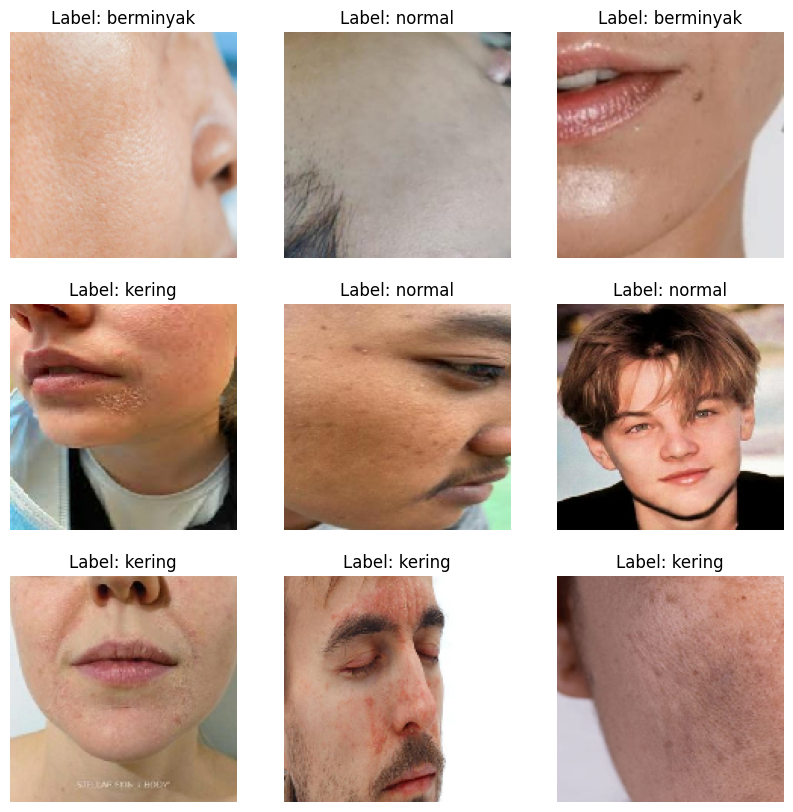

In [9]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    random_idx = random.randint(0, len(train_df) - 1)
    random_img_path = train_df.iloc[random_idx]['Path']
    random_img_label = train_df.iloc[random_idx]['Label']
    random_img = load_img(random_img_path, target_size=(150, 150))
    plt.imshow(random_img)
    plt.title(f"Label: {random_img_label}")
    plt.axis('off')
plt.show()

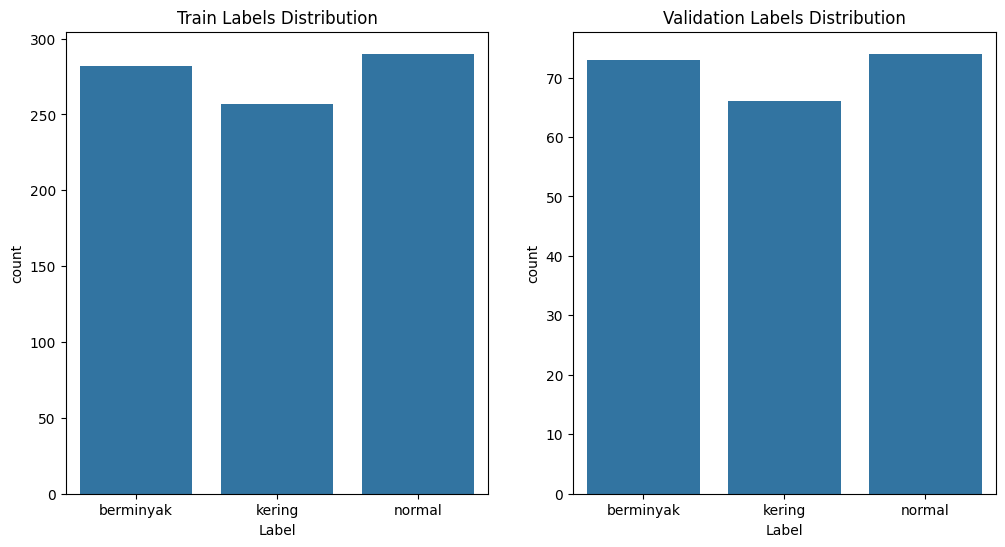

In [10]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(data=train_df, x='Label')
plt.title('Train Labels Distribution')
plt.subplot(1, 2, 2)
sns.countplot(data=val_df, x='Label')
plt.title('Validation Labels Distribution')
plt.show()

## **Build Model with Transfer Learning**

In [11]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
last_layer = base_model.output
x = layers.GlobalAveragePooling2D()(last_layer)
x = layers.Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

# Number of classes
num_classes = train_labels.shape[1]
x = layers.Dense(num_classes, activation='softmax')(x)

# Define the model
model = models.Model(inputs=base_model.input, outputs=x)
model.summary()


17225924/17225924 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                              

In [12]:
# Compile the model
optimizer = optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with the callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callback = AccuracyCallback()

## **Train The Model**

In [13]:
history = model.fit(
    augmented_train_images, augmented_train_labels,
    epochs=10,
    batch_size=16,
    validation_data=(augmented_val_images, augmented_val_labels),
    callbacks=[callback, early_stopping]
)

Epoch 1/10
260/260 [==============================] - 39s 81ms/step - loss: 3.8735 - accuracy: 0.4227 - val_loss: 3.0206 - val_accuracy: 0.6366
Epoch 2/10
260/260 [==============================] - 17s 65ms/step - loss: 3.4204 - accuracy: 0.5539 - val_loss: 2.7496 - val_accuracy: 0.7700
Epoch 3/10
260/260 [==============================] - 17s 66ms/step - loss: 3.0563 - accuracy: 0.6724 - val_loss: 2.8390 - val_accuracy: 0.7662
Epoch 4/10
260/260 [==============================] - 19s 73ms/step - loss: 2.7881 - accuracy: 0.7686 - val_loss: 2.6775 - val_accuracy: 0.8225
Epoch 5/10
260/260 [==============================] - 19s 75ms/step - loss: 2.5918 - accuracy: 0.8210 - val_loss: 2.4287 - val_accuracy: 0.8901
Epoch 6/10
260/260 [==============================] - 22s 86ms/step - loss: 2.3942 - accuracy: 0.8741 - val_loss: 2.3758 - val_accuracy: 0.8873
Epoch 7/10
260/260 [==============================] - 18s 71ms/step - loss: 2.2777 - accuracy: 0.9008 - val_loss: 2.2760 - val_accuracy:

## **Grafik Accuracy and Loss for Training and Validation**

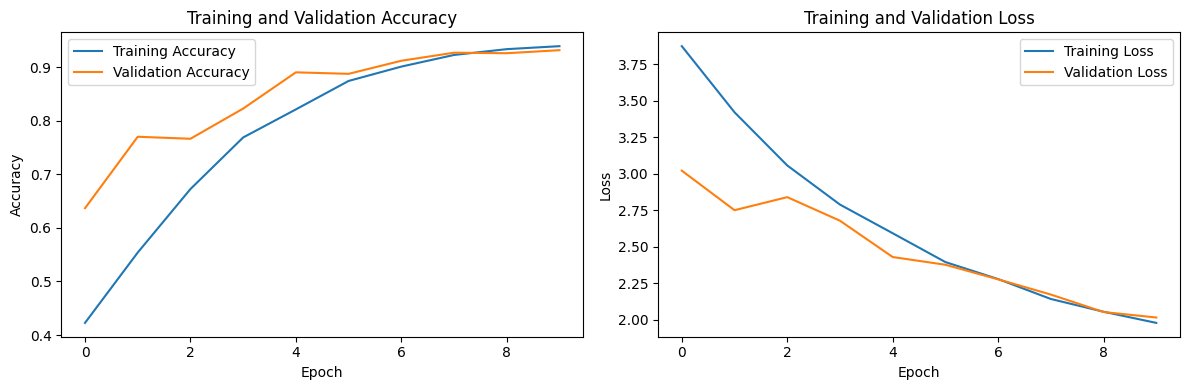

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

## **Plot Confusion Matrix for Train and Validation Set**

In [15]:
def plot_confusion_matrix(y_true, y_pred, classes, title=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.xticks(rotation=45)
    fmt = '.2f'  # Format to two decimal places
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


34/34 [==============================] - 3s 35ms/step


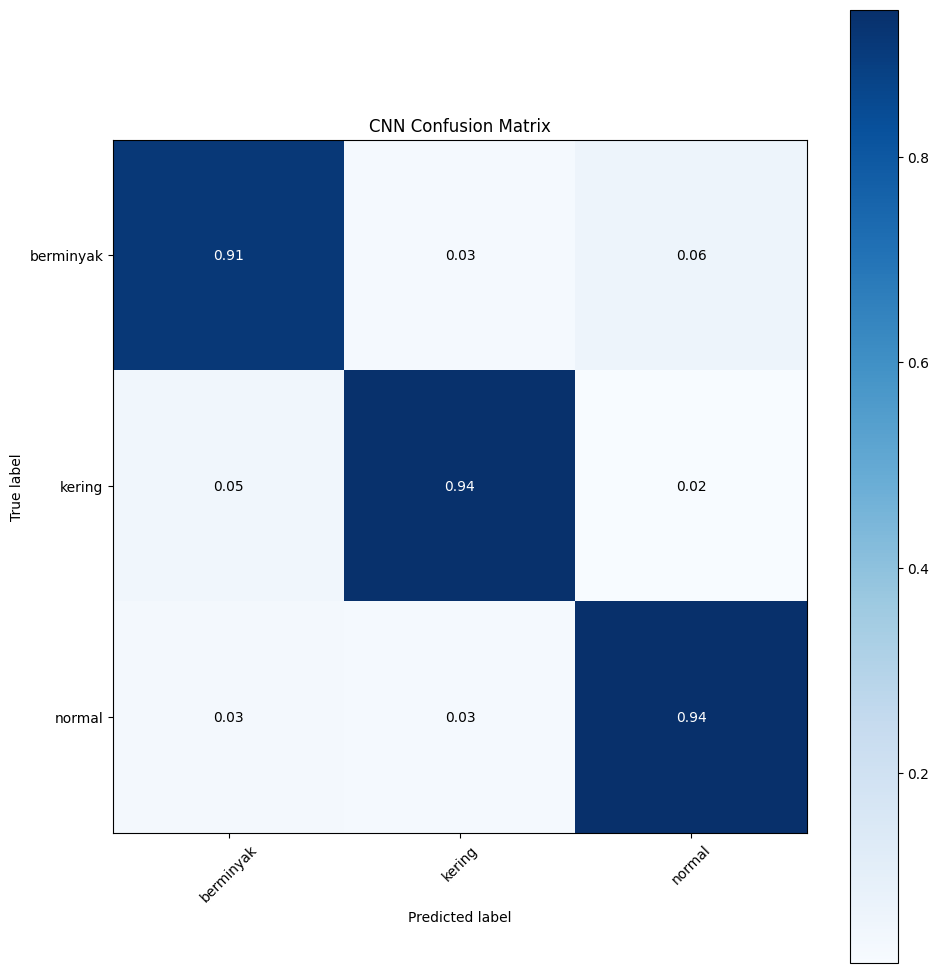

In [16]:
# Generate predictions using validation data directly
y_val_pred = model.predict(augmented_val_images)
y_val_pred_labels = np.argmax(y_val_pred, axis=1)

# Get the unique class names or labels from your dataset
class_names = list(train_df['Label'].unique())

# Convert validation labels from one-hot encoded to class indices if needed
val_labels_true = np.argmax(augmented_val_labels, axis=1)

# Ensure that the number of unique classes matches
assert len(class_names) == len(np.unique(val_labels_true)), "Number of classes mismatch"

# Plot confusion matrix
plot_confusion_matrix(val_labels_true, y_val_pred_labels, classes=class_names, title='CNN Confusion Matrix')
plt.show()

In [17]:
val_loss, val_acc = model.evaluate(augmented_val_images, augmented_val_labels)
print(f'Validation Accuracy: {val_acc}')

print("Classification Report:")
print(classification_report(val_labels_true, y_val_pred_labels, target_names=class_names))

34/34 [==============================] - 1s 41ms/step - loss: 2.0143 - accuracy: 0.9315
Validation Accuracy: 0.9314553737640381
Classification Report:
              precision    recall  f1-score   support

   berminyak       0.93      0.91      0.92       365
      kering       0.94      0.94      0.94       330
      normal       0.93      0.94      0.94       370

    accuracy                           0.93      1065
   macro avg       0.93      0.93      0.93      1065
weighted avg       0.93      0.93      0.93      1065



## **Test Generator**

In [18]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'skin2_split/test/',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

Found 106 images belonging to 3 classes.


## **Evaluate The Model on The Test Set**

In [19]:
test_generator.reset()
test_pred = model.predict(test_generator)
y_test_pred_labels = np.argmax(test_pred, axis=1)
test_labels = test_generator.classes
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

7/7 [==============================] - 1s 52ms/step - loss: 2.1790 - accuracy: 0.9151
Test accuracy: 0.9150943160057068


## **Plot Confusion Matrix for Test Set**

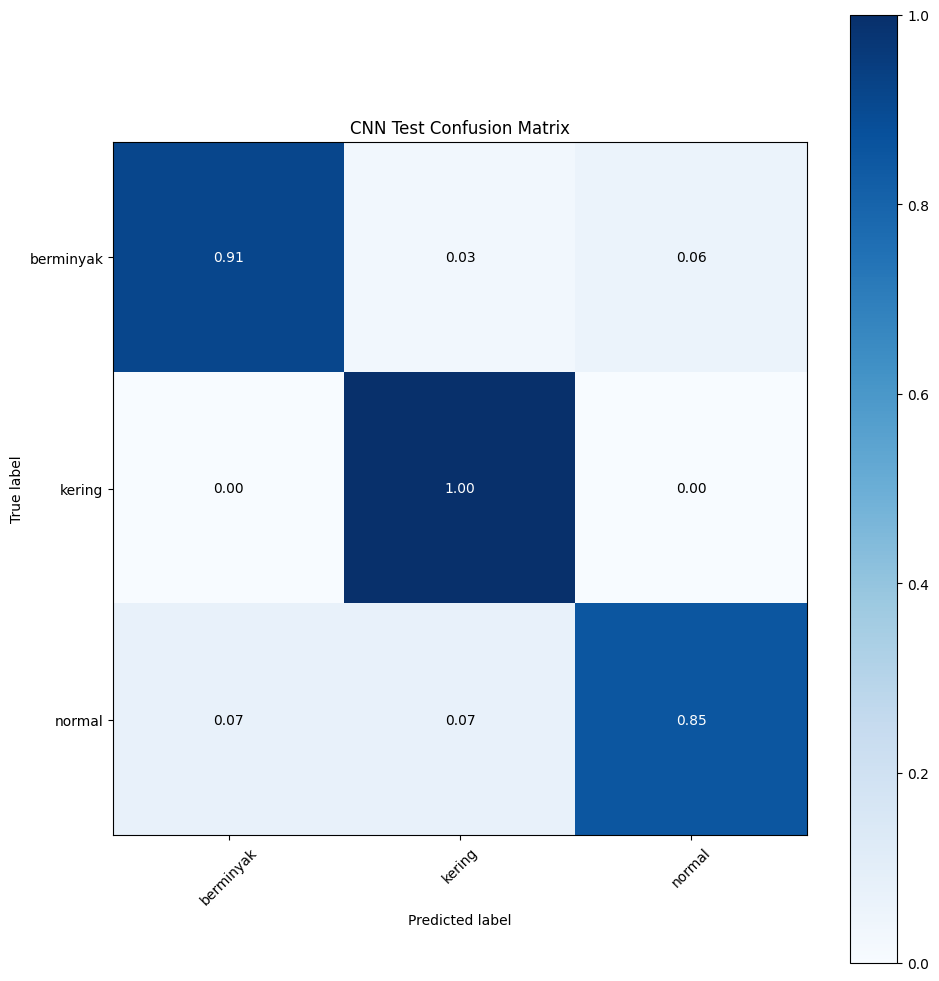

In [20]:
plot_confusion_matrix(test_labels, y_test_pred_labels, classes=class_names, title='CNN Test Confusion Matrix')
plt.show()

In [21]:
# Classification report for test data
print("Classification Report for CNN Model on Test Data:")
print(classification_report(test_labels, y_test_pred_labels, target_names=class_names))

Classification Report for CNN Model on Test Data:
              precision    recall  f1-score   support

   berminyak       0.91      0.91      0.91        34
      kering       0.89      1.00      0.94        31
      normal       0.95      0.85      0.90        41

    accuracy                           0.92       106
   macro avg       0.91      0.92      0.92       106
weighted avg       0.92      0.92      0.91       106



1/1 [==============================] - 0s 29ms/step


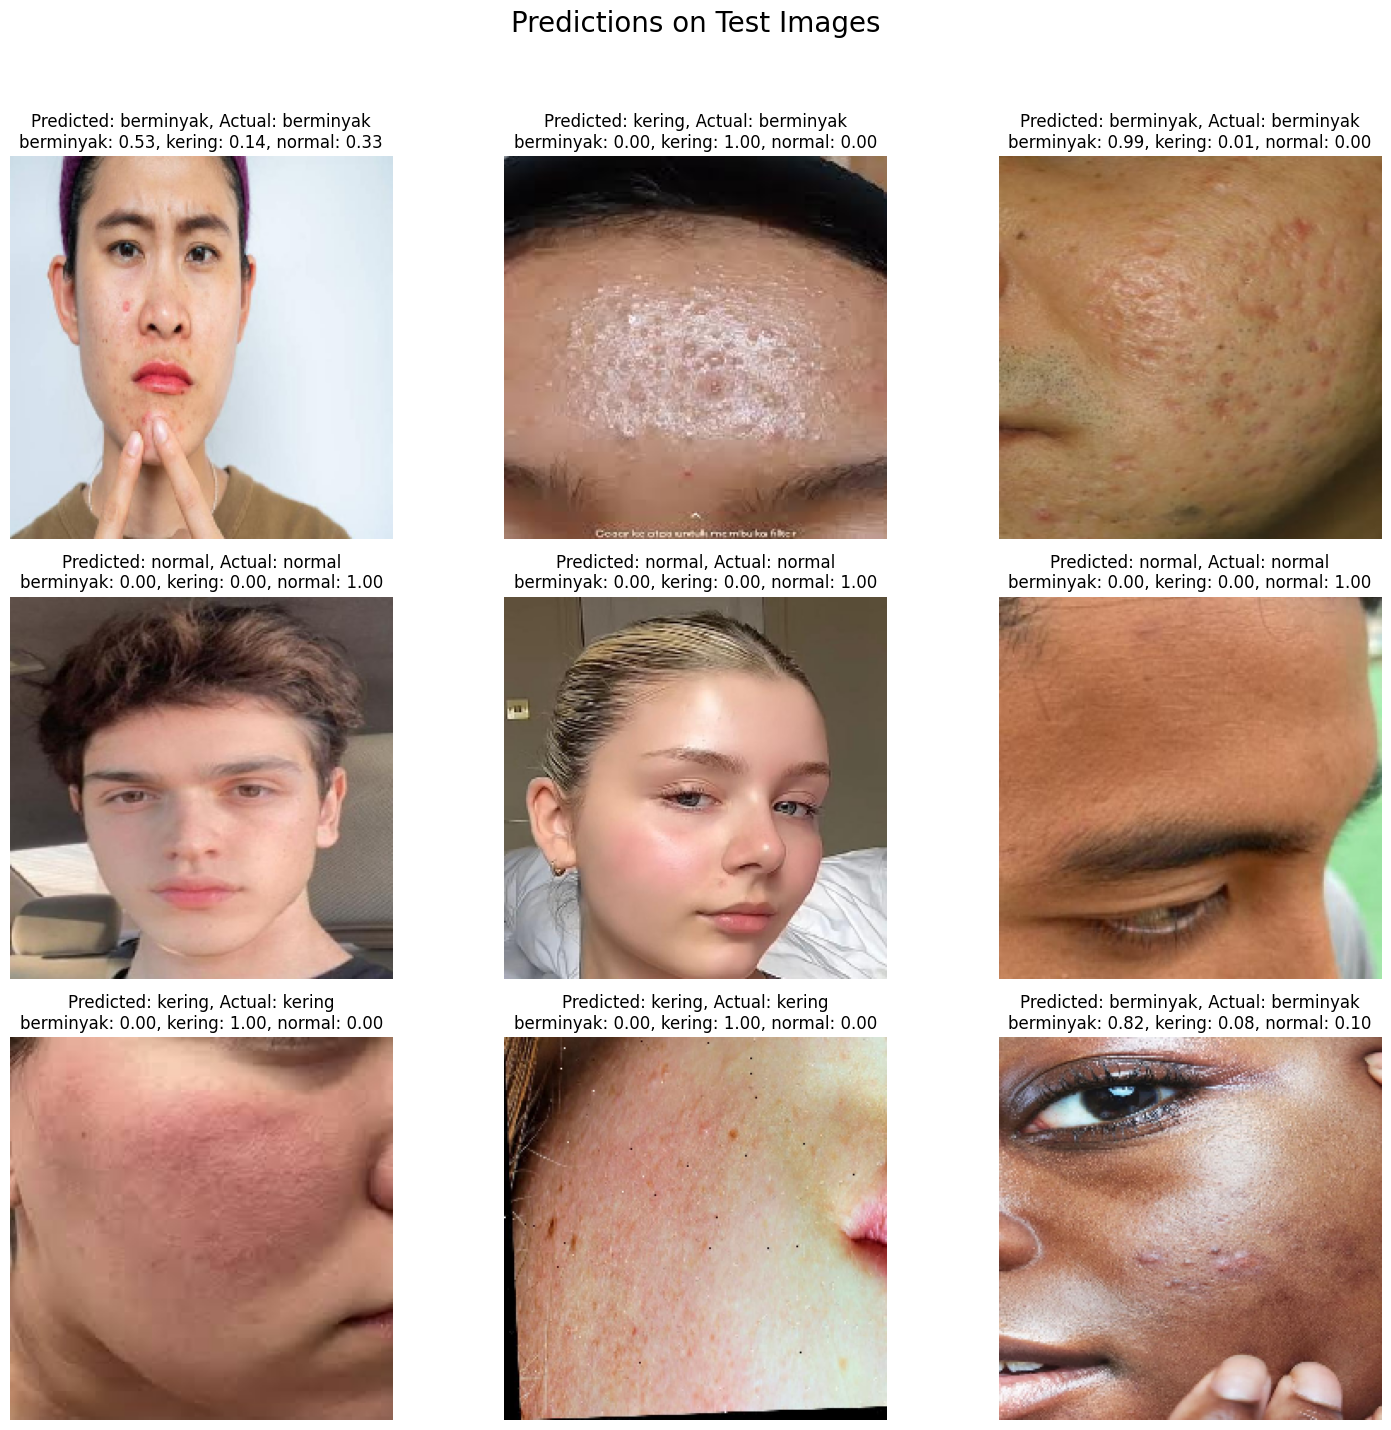

In [22]:
plt.figure(figsize=(15, 15))
plt.suptitle('Predictions on Test Images', fontsize=20)

num_samples = 9
for i in range(num_samples):
    plt.subplot(3, 3, i + 1)
    img_index = random.randint(0, len(test_generator.filenames) - 1)
    img_path = test_generator.filenames[img_index]

    # Construct the full path to the image
    full_img_path = os.path.join(test_generator.directory, img_path)

    img = load_img(full_img_path, target_size=(224, 224))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0 
    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]

    # Extract the true class label from the directory structure
    true_class = os.path.basename(os.path.dirname(full_img_path))

    labels_str = ', '.join([f'{class_names[j]}: {prediction[0][j]:.2f}' for j in range(len(class_names))])
    plt.title(f'Predicted: {predicted_class}, Actual: {true_class}\n{labels_str}', fontsize=12)
    plt.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## **Saved The Model**

In [23]:
saved_model_path = "./my_model.h5"

model.save(saved_model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## **Install Tensorflowjs**

In [1]:
!pip install tensorflowjs

## **Deploy Model Keras to Tensorflowjs**

In [2]:
!tensorflowjs_converter --input_format=keras /content/my_model.h5 /content/

2024-06-14 13:09:40.648056: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-14 13:09:42.382449: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## **Zip The Model**

In [3]:
!zip model.zip *.bin model.json

  adding: group1-shard1of5.bin (deflated 7%)
  adding: group1-shard2of5.bin (deflated 7%)
  adding: group1-shard3of5.bin (deflated 7%)
  adding: group1-shard4of5.bin (deflated 7%)
  adding: group1-shard5of5.bin (deflated 8%)
  adding: model.json (deflated 95%)
